# Example of usage Spark OCR for Tables Detections

This notebook demonstrate pipeline for detect tables in image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [15]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"
imagePath = "./data/tab_images/cTDaR_*.jpg"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [5]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [6]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.1")

spark

Spark version: 3.0.2
Spark OCR version: 3.9.0



## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


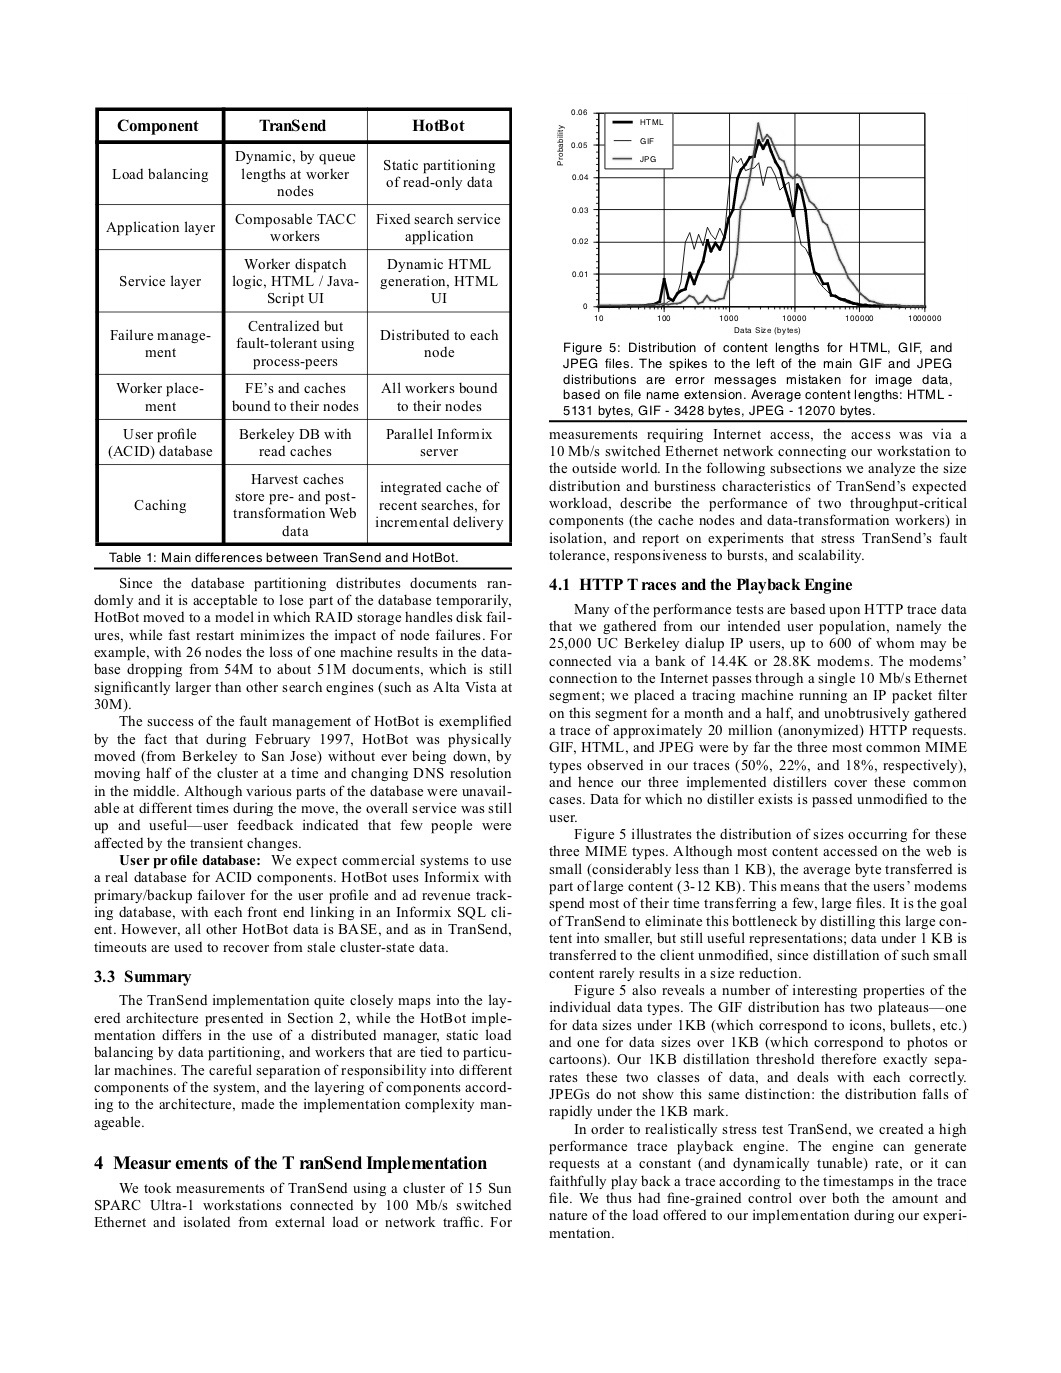


    Image #1:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


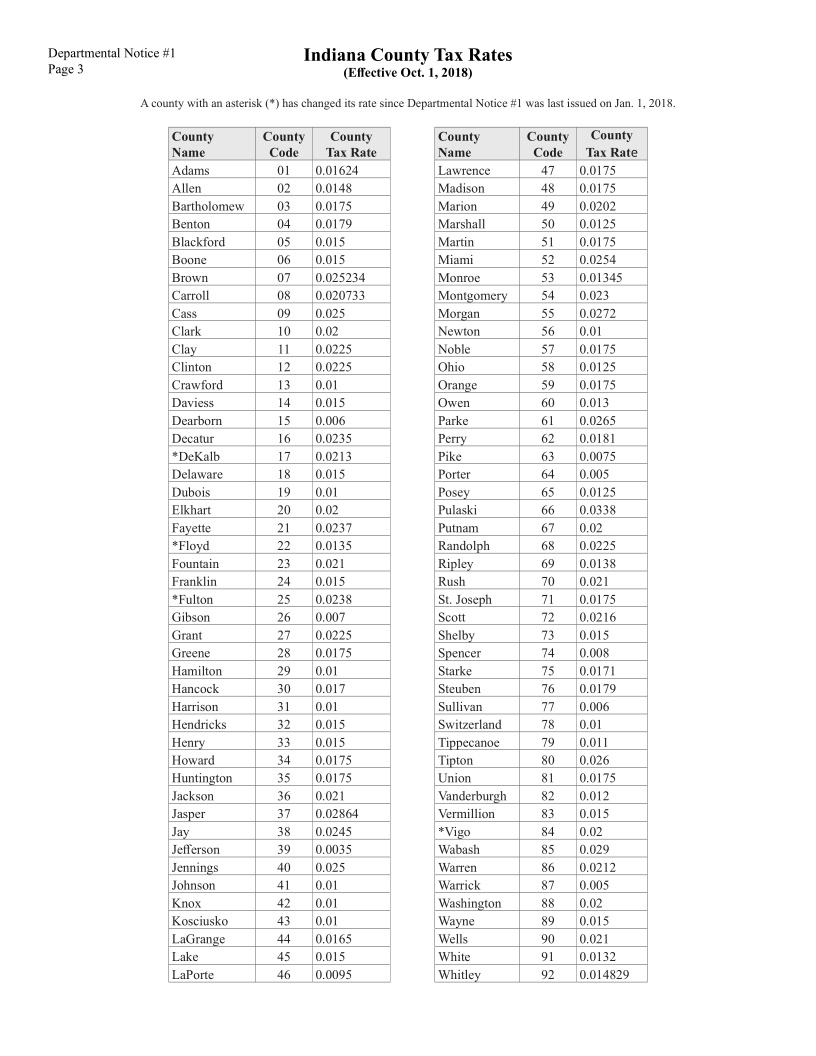

In [16]:
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [17]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("table_regions")

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("table_regions")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


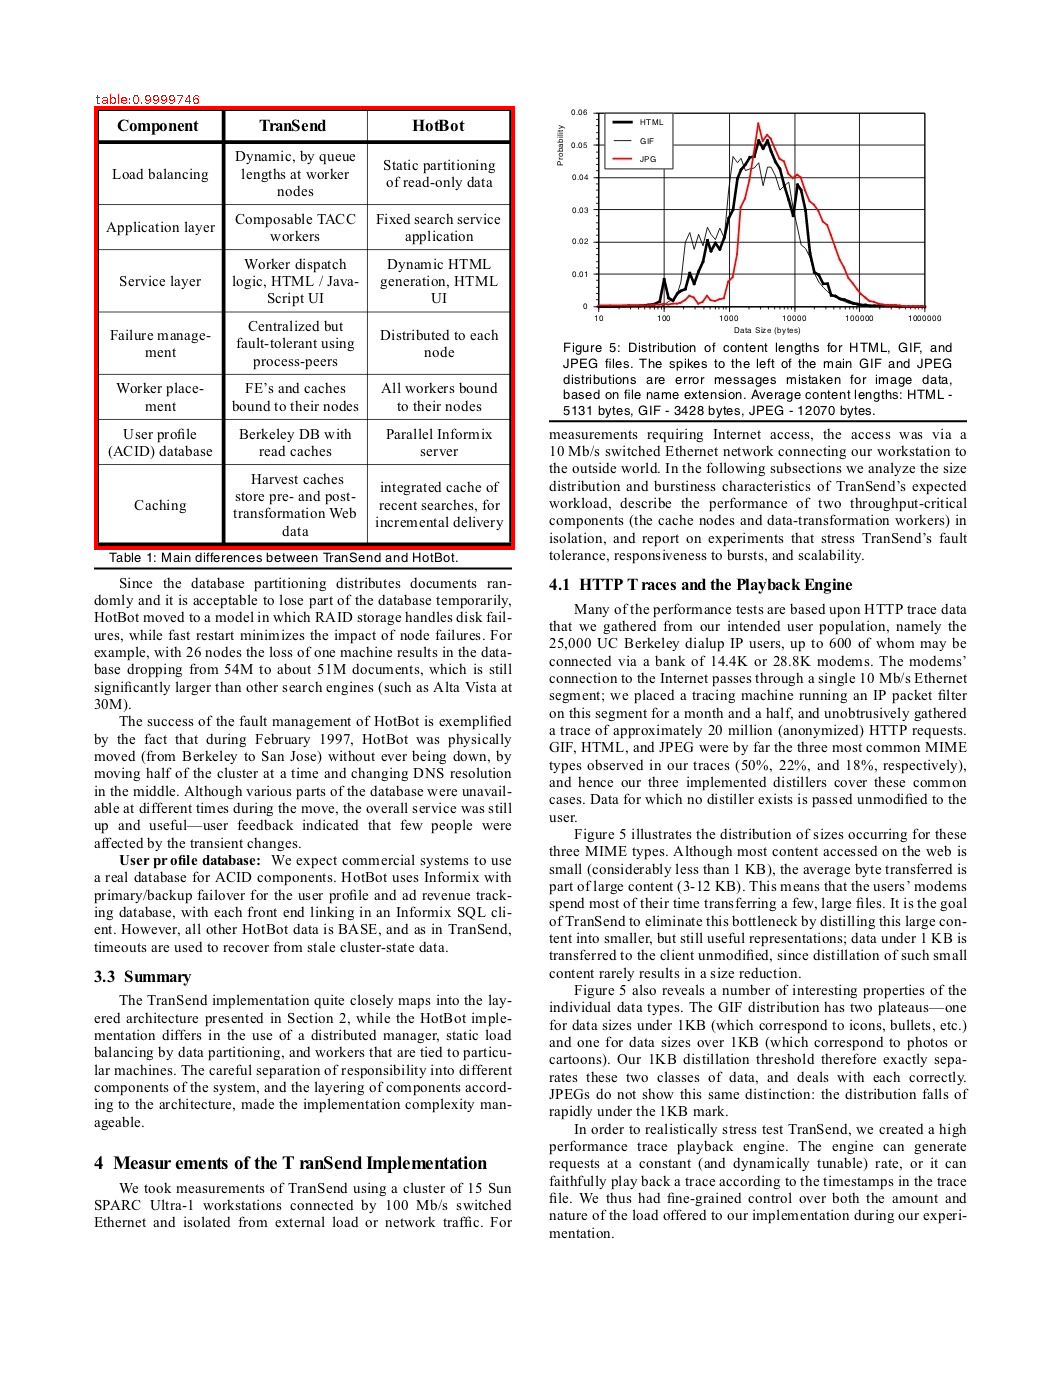


    Image #1:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


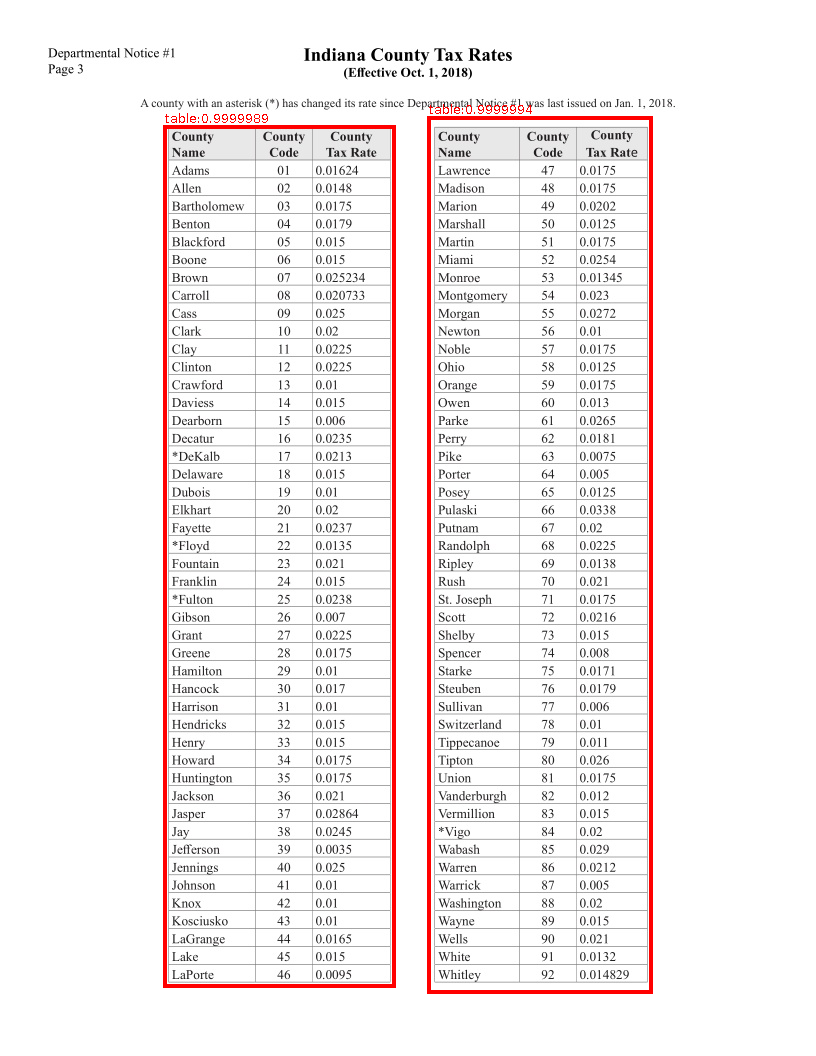

In [18]:
result = pipeline.transform(image_df)
display_images(result, "image_with_regions")

## Apply boundaries correction

### Show result without correction


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/MicrosoftTeams-image (2).png
    Resolution: 0 dpi
    Width: 985 px
    Height: 1097 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


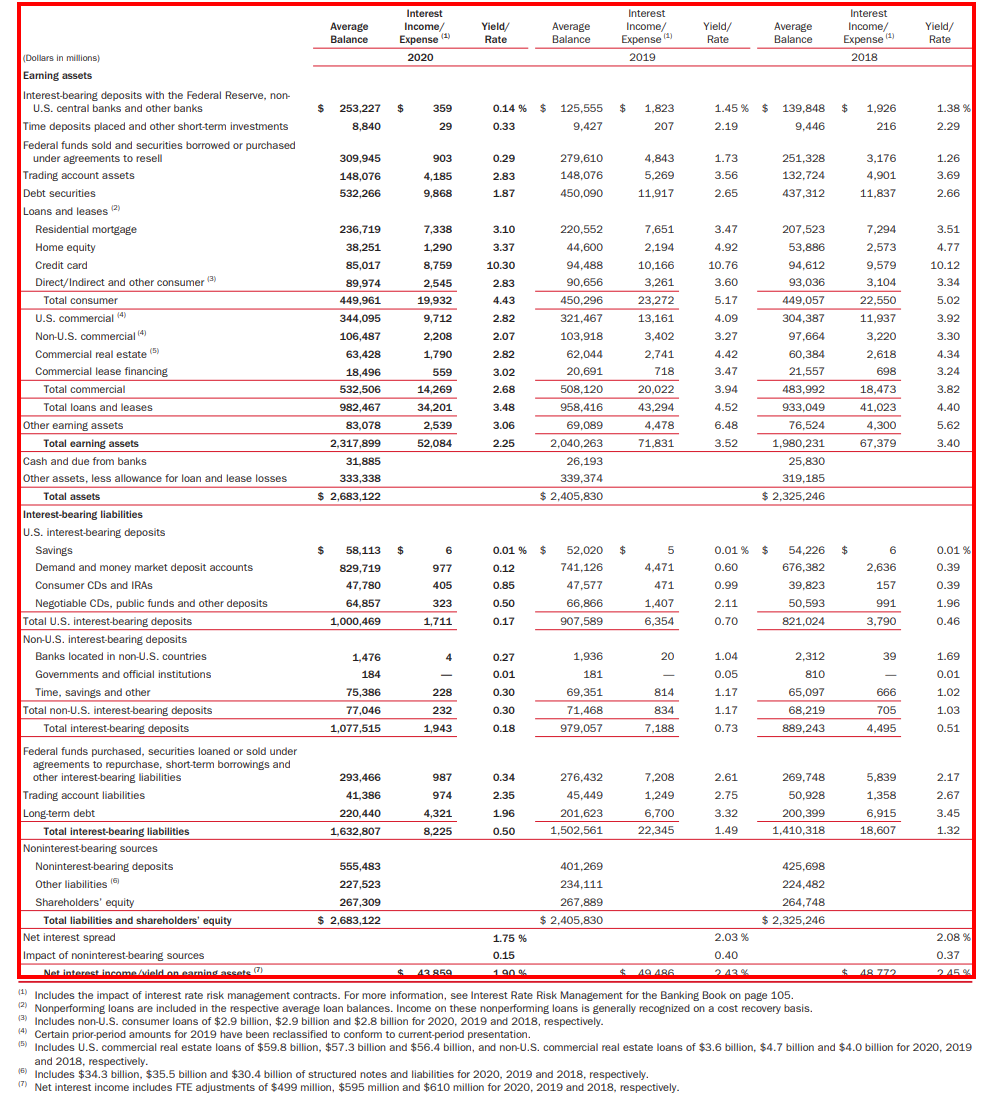

In [10]:
imagePath1 = "./data/tab_images/MicrosoftTeams-image (2).png"
image_df1 = spark.read.format("binaryFile").load(imagePath1)
result = pipeline.transform(image_df1)
display_images(result, "image_with_regions")

### Apply correction

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB

    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images/MicrosoftTeams-image (2).png
    Resolution: 0 dpi
    Width: 985 px
    Height: 1097 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


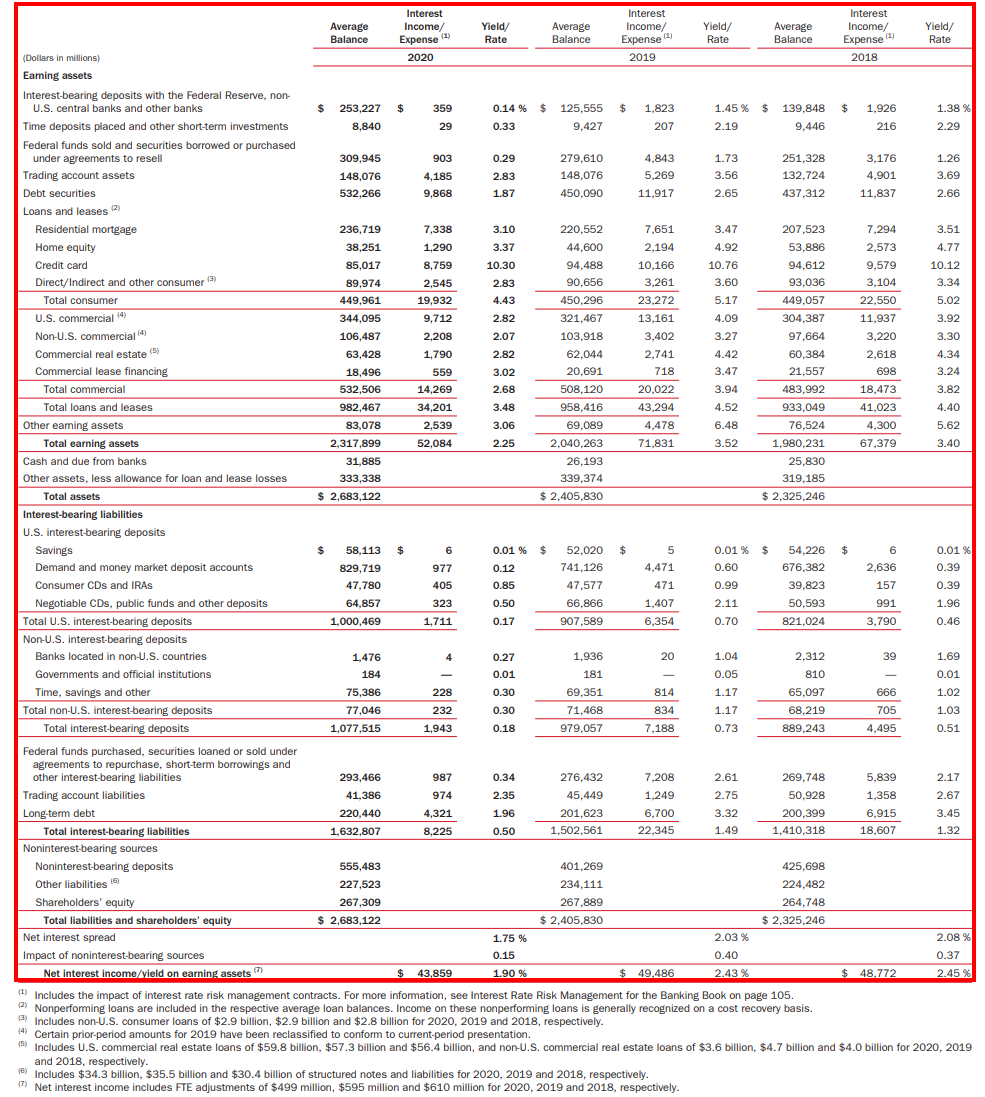

In [11]:
table_detector_corr = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector_corr.setInputCol("image")
table_detector_corr.setOutputCol("table_regions")
table_detector_corr.setApplyCorrection(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector_corr,
    draw_regions
])

result = pipeline.transform(image_df1)
display_images(result, "image_with_regions")